In [136]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from etna.datasets import TSDataset
from etna.pipeline import Pipeline
from etna.models import (
    ProphetModel,
    CatBoostMultiSegmentModel,
    AutoARIMAModel
)

from etna.analysis import plot_forecast 
from sklearn.metrics import mean_absolute_percentage_error

from etna.transforms import DateFlagsTransform

from etna.models import CatBoostMultiSegmentModel
from etna.transforms import DateFlagsTransform
from etna.transforms import DensityOutliersTransform
from etna.transforms import FourierTransform
from etna.transforms import LagTransform
from etna.transforms import LinearTrendTransform
from etna.transforms import MeanTransform
from etna.transforms import SegmentEncoderTransform
from etna.transforms import TimeSeriesImputerTransform
from etna.transforms import TrendTransform

from etna.datasets import TSDataset
from etna.pipeline import Pipeline
from etna.transforms import DateFlagsTransform
from etna.transforms import LagTransform

In [137]:
date_pnl = pd.read_feather('date_pnl.feather')
date_pnl['ds'] = pd.to_datetime(date_pnl['ds'])
date_pnl = date_pnl.rename(columns={'ds': 'timestamp', 'y': 'target'})
date_pnl = date_pnl.drop('pnl', axis=1)


In [138]:
ruonia = pd.read_excel('ruonia.xlsx')
date_pnl = date_pnl.merge(ruonia, on='timestamp', how='left')

In [139]:
date_pnl['month'] = date_pnl['timestamp'].dt.to_period('M')
for z in ['KNR', 'RF', 'USA']:
    inflation = pd.read_excel(f'inflation{z}.xlsx')
    inflation['month'] = pd.to_datetime(inflation['month'].astype(str), format='%m.%Y')
    inflation['month'] = inflation['month'].dt.to_period('M')
    date_pnl = date_pnl.merge(inflation, on='month')

date_pnl = date_pnl.drop('month', axis=1)

In [140]:
date_pnl

,timestamp,target,ruo,inflationKNR,inflationRF,inflationUSA
0,2022-08-11,3.467917e+06,8.07,0.025,0.143,0.083
1,2022-08-12,1.343008e+07,8.19,0.025,0.143,0.083
2,2022-08-15,1.435988e+07,8.08,0.025,0.143,0.083
3,2022-08-16,1.700536e+07,7.94,0.025,0.143,0.083
4,2022-08-17,3.310824e+07,7.86,0.025,0.143,0.083
...,...,...,...,...,...,...
555,2024-11-12,4.527376e+09,21.09,0.002,0.089,0.027
556,2024-11-13,4.528945e+09,20.85,0.002,0.089,0.027
557,2024-11-18,4.548336e+09,20.75,0.002,0.089,0.027
558,2024-11-19,4.560936e+09,20.65,0.002,0.089,0.027


In [141]:
date_pnl['segment'] = 'main'
df_exog = date_pnl[['timestamp', 'segment', 'ruo', 'inflationKNR', 'inflationRF', 'inflationUSA']]
df_exog['ruo'] = df_exog['ruo'].ffill()
ts_with_params = TSDataset(date_pnl[(date_pnl.timestamp>pd.to_datetime('2022-09-15'))&(date_pnl.timestamp<pd.to_datetime('2023-09-15'))], freq="B", df_exog=df_exog, known_future=['ruo', 'inflationKNR', 'inflationRF', 'inflationUSA'])

In [142]:
date_pnl = date_pnl.drop(['ruo', 'inflationKNR', 'inflationRF', 'inflationUSA'], axis=1)
ts = TSDataset(date_pnl[(date_pnl.timestamp>pd.to_datetime('2022-09-15'))&(date_pnl.timestamp<pd.to_datetime('2023-09-15'))], freq="B")
ts.loc[:, ('main', 'target')] = ts.loc[:, ('main', 'target')].ffill()
ts_with_params.loc[:, ('main', 'target')] = ts_with_params.loc[:, ('main', 'target')].ffill()

In [143]:
def experiment(model, kwargs, ts, test_days):
    model_name = type(model)
    train, test = ts.train_test_split(test_size=test_days)
    pipeline = Pipeline(model=model, horizon=test_days + 309, **kwargs)
    pipeline.fit(train)
    forecast = pipeline.forecast()
    prediction = forecast.df.reset_index()
    plot_forecast(forecast_ts=forecast, test_ts=test, train_ts=train)

    mape = mean_absolute_percentage_error(
        test.loc[:, ('main', 'target')],
        prediction[prediction.timestamp<pd.to_datetime('2023-09-15')].main.target
    )
    print(f'{model_name} MAPE: {mape}')

    return model_name, mape, prediction

In [144]:
models = [
    (ProphetModel(), {}),
    (AutoARIMAModel(), {}),
]

models_with_param = [
    (CatBoostMultiSegmentModel(), {'transforms':
        [
            DensityOutliersTransform(in_column="target", distance_coef=3.0),
            TimeSeriesImputerTransform(in_column="target", strategy="forward_fill"),
            LinearTrendTransform(in_column="target"),
            TrendTransform(in_column="target", out_column="trend"),
            LagTransform(in_column="target", lags=list(range(15, 122)), out_column="target_lag"),
            DateFlagsTransform(week_number_in_month=True, out_column="date_flag"),
            FourierTransform(period=360.25, order=6, out_column="fourier"),
            SegmentEncoderTransform(),
            MeanTransform(in_column=f"target_lag_{15}", window=7),
        ]
    })
]

00:25:30 - cmdstanpy - INFO - Chain [1] start processing
00:25:31 - cmdstanpy - INFO - Chain [1] done processing


<class 'etna.models.prophet.ProphetModel'> MAPE: 0.0489668191268106
<class 'etna.models.autoarima.AutoARIMAModel'> MAPE: 0.06115560041687807
segment  timestamp          main
feature                   target
354     2024-11-14  3.336242e+09
355     2024-11-15  3.339821e+09
356     2024-11-18  3.345357e+09
357     2024-11-19  3.352347e+09
358     2024-11-20  3.358051e+09


ValueError: Given wide dataframe doesn't have all combinations of pairs (segment, feature)!

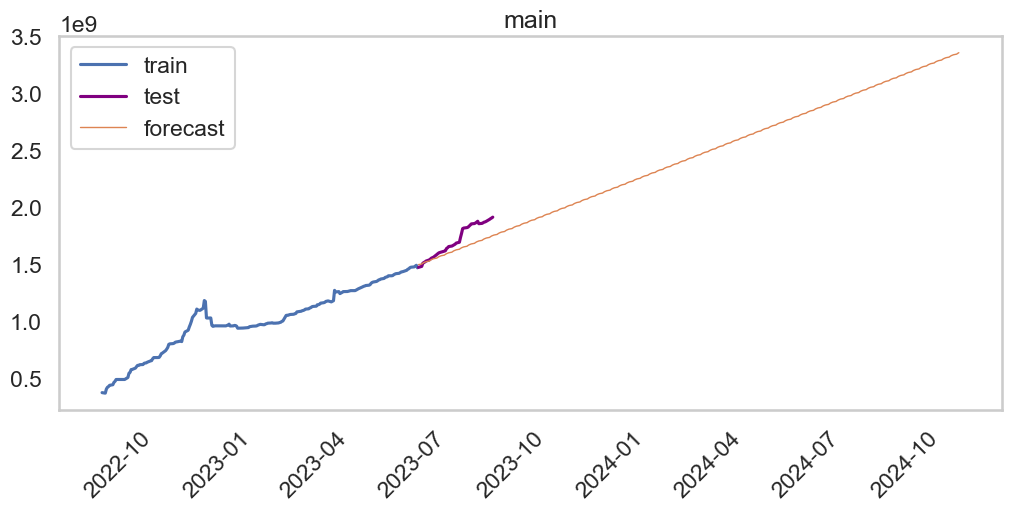

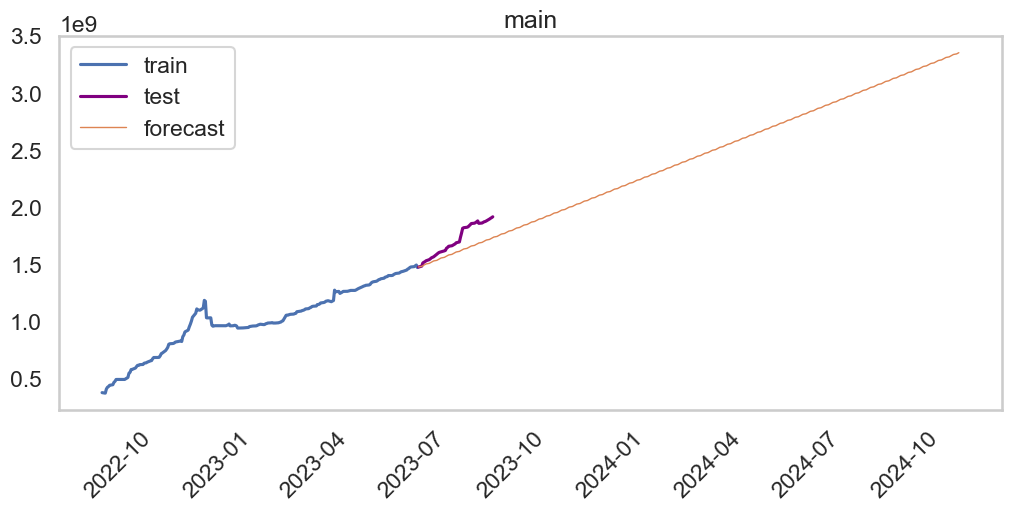

In [145]:
result = []
for model, kwargs in models:
    prediction = experiment(model, kwargs, ts, 50)
    result.append(prediction)
    prediction[-1][[('timestamp', ''), ('main', 'target')]].set_axis(['timestamp', 'target'], axis=1).to_csv(f'./output/model{len(result)}.csv', index=False, encoding='utf-8')

print(result[0][-1].tail())

for model, kwargs in models_with_param:
    prediction = experiment(model, kwargs, ts_with_params, 50)
    result.append(prediction)
    prediction[-1][[('timestamp', ''), ('main', 'target')]].set_axis(['timestamp', 'target'], axis=1).to_csv(f'./output/model{len(result)}.csv', index=False, encoding='utf-8')
    

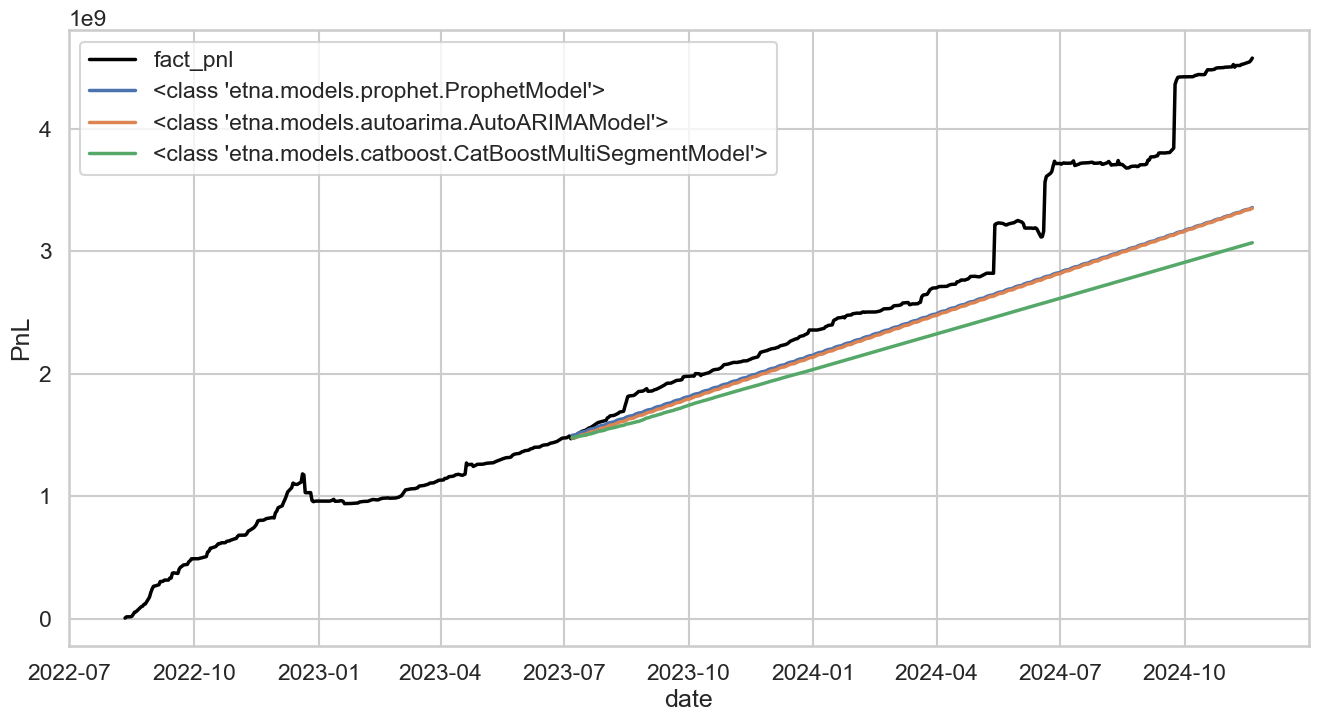

In [121]:
sns.set(style='whitegrid', context='talk')

plt.figure(figsize=(16, 8))
plt.plot(date_pnl.timestamp, date_pnl.target, label='fact_pnl', linewidth=2.5, color='black')
for i in range(len(models) + len(models_with_param)):
    plt.plot(result[i][-1].timestamp, result[i][-1].main.target, label=result[i][0], linewidth=2.5)

plt.xlabel('date')
plt.ylabel('PnL')
plt.legend()
plt.show()

In [122]:
fact_pnl = date_pnl[date_pnl['timestamp'] == pd.to_datetime('2024-11-20')]['target']

ΔPnL

In [123]:
for predict in result:
    print(f'{predict[0]} MAPE: {predict[1]}')
    print(float(fact_pnl) - float(predict[-1][predict[-1]['timestamp'] == pd.to_datetime('2024-11-20')][('main', 'target')]))

<class 'etna.models.prophet.ProphetModel'> MAPE: 0.0489668191268106
1221021429.7665935
<class 'etna.models.autoarima.AutoARIMAModel'> MAPE: 0.06115560041687807
1227123470.3731203
<class 'etna.models.catboost.CatBoostMultiSegmentModel'> MAPE: 0.07677064883097716
1508662948.4813547


2024-05-13	2820906587
2024-05-14	3217444529


2024-06-19	3163958674
2024-06-20	3566628623
2024-06-21	3612123970


2024-09-23	3843280485
2024-09-24	4363909492